# Outliers

In [4]:
import numpy as np
import pandas as pd
from scipy import stats

In [5]:
df = pd.read_csv('../datasets/house_prices/HousePrices.csv')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


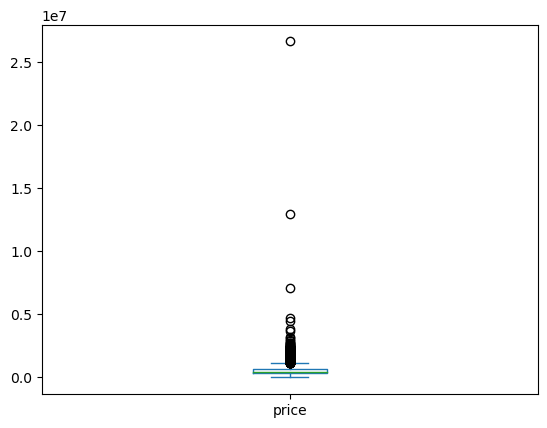

In [11]:
df['price'].plot.box();

### Remove outliers using the z-score method

Assuming normally-distributed data, a *z-score* indicates how many standard deviations away from the mean a data point (say, $x$) is: 

$$ z = \frac{x-\mu}{\sigma} $$

A data point that lies further than three standard deviations from the mean is considered to be an *outlier*. i.e., if $|z_i| > 3$, then $x_i$ is an outlier.

Here's an example code snippet to remove outliers using the z-score method:

In [14]:
df['price'].min(), df['price'].max()

(0.0, 26590000.0)

In [15]:
stats.zscore(df['price']).min(), stats.zscore(df['price']).max()

(-0.9790511150522764, 46.18528724257905)

In [16]:
# Outliers data points based on price being further than 3 standard deviations away from the mean
threshold = 3
outliers_z = df[np.abs(stats.zscore(df['price'])) > threshold]
df_z = df[np.abs(stats.zscore(df['price'])) <= threshold]

In [17]:
# minimum outlier price
outlier_z_min = outliers_z['price'].min()
outlier_z_min

2250000.0

In [18]:
df_z[df_z['price'] >= outlier_z_min]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country


array([[<Axes: title={'center': 'price'}>]], dtype=object)

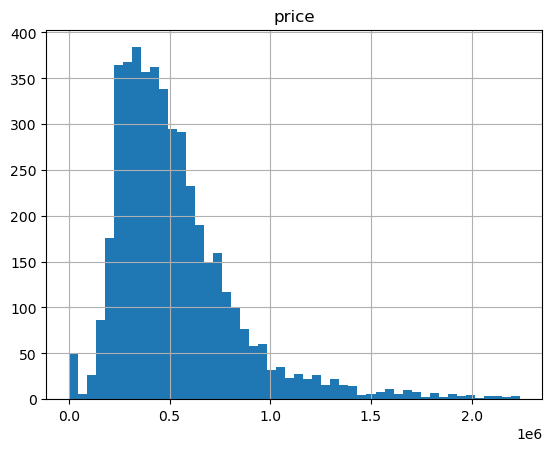

In [19]:
df_z.hist(column='price', bins=50)

In [20]:
len(df), len(df_z), len(outliers_z)

(4600, 4566, 34)

### Remove outliers using the IQR method

By convention, a data point may be considered to be an outlier if it lies outside of the interquartile range (IQR) by more than 1.5 times the IQR. i.e., if $x_i < Q_1 - 1.5 \times \text{IQR}$ or $x_i > Q_3 + 1.5 \times \text{IQR}$, then $x_i$ is an outlier.

<img height="360" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/800px-Boxplot_vs_PDF.svg.png">

Figure: Box plot and probability density function of a normal distribution $N(0, σ^2)$. Source: https://en.wikipedia.org/wiki/Probability_density_function

In [21]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold value
threshold = 1.5

# Identify and remove outliers
outliers_iqr = df[(df['price'] < Q1 - threshold * IQR) | (df['price'] > Q3 + threshold * IQR)]
df_iqr = df[(df['price'] >= Q1 - threshold * IQR) & (df['price'] <= Q3 + threshold * IQR)]

In [22]:
# minimum outlier price
outlier_iqr_min = outliers_iqr['price'].min()
outlier_iqr_min

1157200.0

In [23]:
# compare the two
print(f'Outlier min price using z-score: {outlier_z_min}')
print(f'Outlier min price using IQR:     {outlier_iqr_min}')

Outlier min price using z-score: 2250000.0
Outlier min price using IQR:     1157200.0


## How to handle data that won't yield to either Z-score or IQR methods?

- Normalize: log1p, sqrt, boxcox, etc.
- Remove outliers using 99th percentile, 95th percentile, etc.

Let's look at another dataset that has skewed `population` column, and see how we can remove outliers from it.

1. First we will use Z-score and IQR methods
2. Then we will look at a third method: transformation then cutting from the 99th percentile

In [25]:
import pandas as pd

housing = pd.read_csv("../datasets/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [28]:
# let's first apply the zscore method
threshold = 3
housing_z = housing[np.abs(stats.zscore(housing['population'])) <= threshold]

# now let's apply the iqr method
housing_iqr = housing[(housing['population'] >= Q1 - threshold * IQR) & (housing['population'] <= Q3 + threshold * IQR)]

<Axes: >

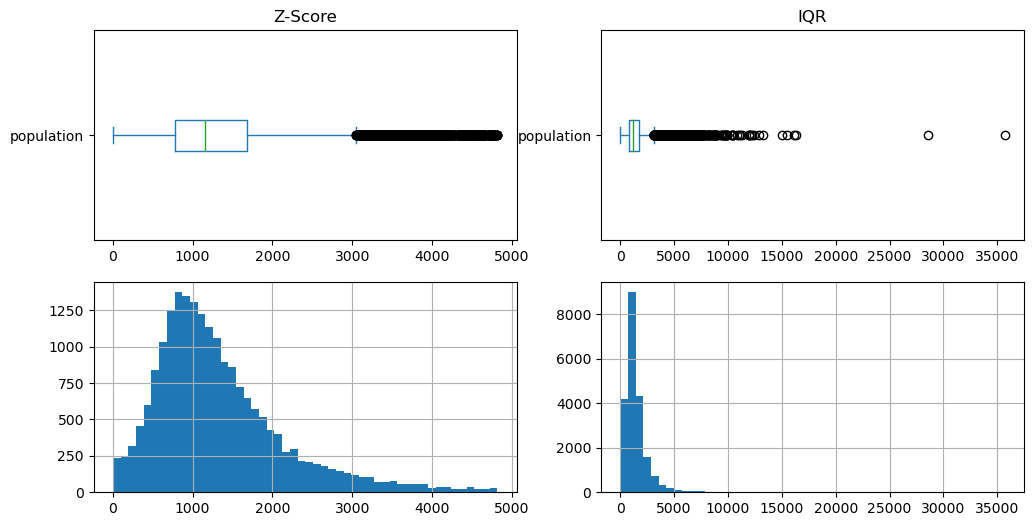

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# box plot
housing_z['population'].plot.box(ax=ax.flat[0], title="Z-Score", vert=False)
housing_iqr['population'].plot.box(ax=ax.flat[1], title="IQR", vert=False)
# histogram
housing_z['population'].hist(ax=ax.flat[2], bins=50)
housing_iqr['population'].hist(ax=ax.flat[3], bins=50)

#### Normalization (transformation)

<Axes: xlabel='population normalized', ylabel='Frequency'>

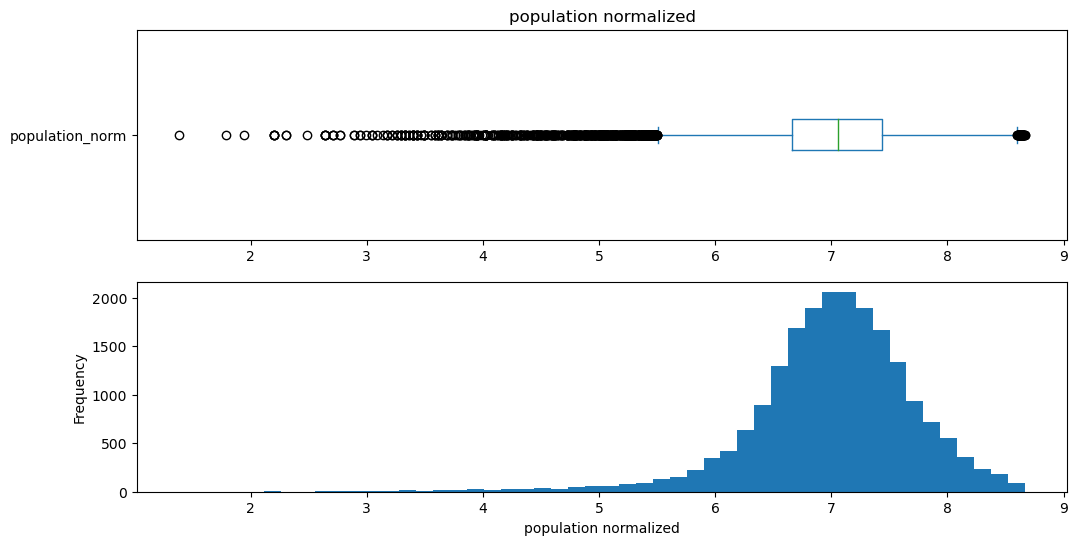

In [40]:
log_population = np.log1p(housing['population'])
# note log1p is used to avoid log(0) which is undefined

# let's then cutoff at the 99th percentile
housing['population_norm'] = log_population[log_population < log_population.quantile(0.99)]

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

housing['population_norm'].plot.box(ax=ax.flat[0], title="population normalized", vert=False)
housing['population_norm'].plot.hist(ax=ax.flat[1], bins=50, xlabel="population normalized")